In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold

In [2]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
camp_data = pd.read_csv('./input/campaign_data.csv')
customer_transaction = pd.read_csv('./input/customer_transaction_data.csv')
customer_demographics = pd.read_csv('./input/customer_demographics.csv')
coupon_item_mapping = pd.read_csv('./input/coupon_item_mapping.csv')
item_data = pd.read_csv('./input/item_data.csv')

In [3]:
train = train.merge(camp_data,on='campaign_id', how = 'left')
test = test.merge(camp_data,on='campaign_id', how = 'left')

In [4]:
print(train.columns)

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'campaign_type', 'start_date', 'end_date'],
      dtype='object')


In [5]:
train.start_date = pd.to_datetime(train.start_date)
train.end_date = pd.to_datetime(train.end_date)
customer_transaction.date = pd.to_datetime(customer_transaction.date)

In [6]:
camp_data.start_date = pd.to_datetime(camp_data.start_date)
camp_data.end_date = pd.to_datetime(camp_data.end_date)

In [7]:
test.start_date = pd.to_datetime(test.start_date)
test.end_date = pd.to_datetime(test.end_date)

In [8]:
train.start_date = pd.to_datetime(train.start_date)
train.start_date = pd.to_datetime(train.start_date)

In [9]:
tr = train[['campaign_id','coupon_id','start_date', 'end_date']]
tr = tr.merge(coupon_item_mapping,on='coupon_id',how='left')

In [10]:
coupon_item_mapping = coupon_item_mapping.merge(item_data,on='item_id',how='left')

In [11]:
coupon_item_set = coupon_item_mapping.groupby('coupon_id')['item_id'].apply(lambda x: list(x)).to_frame().reset_index()
coupon_item_set.columns = ['coupon_id','coupon_item_id']

In [12]:
coupon_brand_set = coupon_item_mapping.groupby('coupon_id')['brand'].apply(lambda x: list(x)).to_frame().reset_index()
coupon_brand_set.columns = ['coupon_id','coupon_brands']

In [13]:
item_selling_price_ = customer_transaction.groupby(['item_id'])['selling_price'].mean().to_frame().reset_index()
item_selling_price_.columns = ['item_id','item_price']

In [14]:
coupon_item_mapping = coupon_item_mapping.merge(item_selling_price_,on='item_id',how='left')
coupon_itemp_set = coupon_item_mapping.groupby('coupon_id')['item_price'].apply(lambda x: list(x)).to_frame().reset_index()
coupon_itemp_set.columns = ['coupon_id','coupon_item_price_list']

In [15]:
#ratio of items greater than 25 percentile , 50 perrcentil, 75 percentile, 90 percentile, 95 percentile
#ratio of  tems greater than mean count

q25 = item_selling_price_.item_price.quantile(.25)
q50 = item_selling_price_.item_price.quantile(.5)
q75 = item_selling_price_.item_price.quantile(.75)
q90 = item_selling_price_.item_price.quantile(.90)
q95 = item_selling_price_.item_price.quantile(.95)


def q1(x):
    print(x)
    retunr (x<q25).sum()
coupon_itemp_set['item_q25_ip'] = coupon_itemp_set.coupon_item_price_list.apply(lambda x: (x<q25).sum())
coupon_itemp_set['item_q50_ip'] = coupon_itemp_set.coupon_item_price_list.apply(lambda x: (x<q50).sum())
coupon_itemp_set['item_q75_ip'] = coupon_itemp_set.coupon_item_price_list.apply(lambda x: (x<q75).sum())
coupon_itemp_set['item_q90_ip'] = coupon_itemp_set.coupon_item_price_list.apply(lambda x: (x<q90).sum())
coupon_itemp_set['item_q95_ip'] = coupon_itemp_set.coupon_item_price_list.apply(lambda x: (x<q95).sum())

In [16]:
customer_transaction = customer_transaction.merge(item_data,on='item_id',how='left')

In [17]:
#feature around selling price
#customer item price ratio

#ratio of items less than customer's median price: done
#ratio of items greater than customer's max price: done
customer_transaction = customer_transaction.merge(item_selling_price_,on='item_id',how='left')
customer_transaction['item_price_ratio'] = customer_transaction.selling_price / customer_transaction.item_price

customer_transaction['customer_median_price'] = customer_transaction.groupby(['customer_id'])['selling_price'].transform('median')

In [18]:
customer_median_price_df = customer_transaction.groupby(['customer_id'])['selling_price'].median().to_frame().reset_index()
customer_median_price_df.columns = ['customer_id','cust_medp']
train = train.merge(customer_median_price_df,on='customer_id',how='left')

In [80]:
test = test.merge(customer_median_price_df,on='customer_id',how='left')

In [61]:
from collections import Counter

def getModerateItemsNum(r):
    #print(r['cust_item_id'])
    #items less than mean proce
    try: 
        mp = r['cust_medp']
        
        #print(mp,r['coupon_item_price_list'].asarray())
        cipl_arr = np.array(r['coupon_item_price_list'])
        coupon_item_price_lt = (cipl_arr<=mp).sum()
        
        #print('getModerateItemsNum',coupon_item_price_lt)
        return coupon_item_price_lt
    except AttributeError:
        cnt=0
    return cnt

def getExpensiveItemsNum(r):
    #print(r['cust_item_id'])
    try: 
        mp = r['cust_medp']
        
        cipl_arr = np.array(r['coupon_item_price_list'])
        coupon_item_price_lt = (cipl_arr>mp).sum()
        return coupon_item_price_lt
    except AttributeError:
        cnt=0
    return cnt

def getCustomerPreferredItems(r):
    try: 
        #cnt = len(r['cust_item_id'].intersection(r['coupon_item_id']))
        c1 = Counter(r['coupon_item_id'])
        c2 = Counter(r['cust_item_id'])
        cks = c2 & c1
        preferred_items_cnt = 0
        
        #print(c2.values,c2)
        
        #take .60 quantile all item values
        qv = np.quantile(np.array(list(c2.values())),0.6)
        
        if len(cks)>0:
            for k in cks:
                if c2[k]>= qv:
                    preferred_items_cnt+=1
        return preferred_items_cnt
    except AttributeError:
        cnt=0
    return cnt


def getMatchingItemsRatio(r):
    #print(r['cust_item_id'])
    try: 
        
        c1 = Counter(r['coupon_item_id'])
        l1 = len(c1.keys())
        c2 = Counter(r['cust_item_id'])
        cks = c2 & c1
        
        s = len(cks)/l1
        return s
    except AttributeError:
        cnt=0
    return cnt

#customer preferred items ( matching items with counts greater then mean)



def getMatchingItems(r):
    #print(r['cust_item_id'])
    try: 
        #cnt = len(r['cust_item_id'].intersection(r['coupon_item_id']))
        c1 = Counter(r['coupon_item_id'])
        c2 = Counter(r['cust_item_id'])
        cks = c2 & c1
        s =0
        
        if len(cks)>0:
            for k in cks:
                s+=c2[k]
        return s
    except AttributeError:
        cnt=0
    return cnt

def getMatchingBrands(r):
    #print(r['cust_brands'],r['coupon_brands'])
    try: 
        #cnt = len(r['cust_item_id'].intersection(r['coupon_item_id']))
        c1 = Counter(r['coupon_brands'])
        c2 = Counter(r['cust_brands'])
        cks = c2 & c1
        s =0
        
        if len(cks)>0:
            for k in cks:
                s+=c2[k]
        return s
    except AttributeError:
        cnt=0
    return cnt

def mergeCustomerData(train,customer_transaction):
    
    customer_od = customer_transaction.groupby('customer_id')['other_discount'].mean().to_frame().reset_index()
    customer_cd = customer_transaction.groupby('customer_id')['coupon_discount'].mean().to_frame().reset_index()
    customer_sp = customer_transaction.groupby('customer_id')['selling_price'].mean().to_frame().reset_index()

    train=train.merge(customer_od,on=['customer_id'],how='left')
    train=train.merge(customer_cd,on=['customer_id'],how='left')
    train=train.merge(customer_sp,on=['customer_id'],how='left')

    customer_od_std = customer_transaction.groupby('customer_id')['other_discount'].std().to_frame().reset_index()
    customer_od_std.columns = ['customer_id','other_discount_std']
    customer_cd_std = customer_transaction.groupby('customer_id')['coupon_discount'].std().to_frame().reset_index()
    customer_cd_std.columns = ['customer_id','coupon_discount_std']
    customer_sp_std = customer_transaction.groupby('customer_id')['selling_price'].std().to_frame().reset_index()
    customer_sp_std.columns = ['customer_id','selling_price_std']
    
    
    customer_od_skew = customer_transaction.groupby('customer_id')['other_discount'].skew().to_frame().reset_index()
    customer_od_skew.columns = ['customer_id','other_discount_skew']
    customer_cd_skew = customer_transaction.groupby('customer_id')['coupon_discount'].skew().to_frame().reset_index()
    customer_cd_skew.columns = ['customer_id','coupon_discount_skew']
    customer_sp_skew = customer_transaction.groupby('customer_id')['selling_price'].skew().to_frame().reset_index()
    customer_sp_skew.columns = ['customer_id','selling_price_skew']
    
    
    
    customer_cnt    = customer_transaction.groupby('customer_id')['selling_price'].count().to_frame().reset_index()
    customer_cnt.columns = ['customer_id','customer_transaction_cnt']

    customer_cnt    = customer_transaction.groupby('customer_id')['selling_price'].count().to_frame().reset_index()
    customer_cnt.columns = ['customer_id','customer_transaction_cnt']

    customer_item_nunq    = customer_transaction.groupby('customer_id')['item_id'].nunique().to_frame().reset_index()
    customer_item_nunq.columns = ['customer_id','customer_items_cnt']

    train=train.merge(customer_od_std,on=['customer_id'],how='left')
    train=train.merge(customer_cd_std,on=['customer_id'],how='left')
    train=train.merge(customer_sp_std,on=['customer_id'],how='left')
    
    train=train.merge(customer_od_skew,on=['customer_id'],how='left')
    train=train.merge(customer_cd_skew,on=['customer_id'],how='left')
    train=train.merge(customer_sp_skew,on=['customer_id'],how='left')
    
    
    train=train.merge(customer_item_nunq,on=['customer_id'],how='left')

    customer_item_set = customer_transaction.groupby('customer_id')['item_id'].apply(lambda x: list(x)).to_frame().reset_index()
    customer_item_set.columns = ['customer_id','cust_item_id']
    
    
    train = train.merge(coupon_item_set,on='coupon_id',how='left')
    train = train.merge(coupon_itemp_set,on='coupon_id',how='left')
    
    #print(train.columns)
    
    
    train = train.merge(customer_item_set,on='customer_id',how='left')
    train = train.merge(customer_cnt ,on='customer_id',how='left')
    train['matching_item'] = train.apply(getMatchingItems,axis=1)
    
    train['matching_item_ratio']= train.apply(getMatchingItemsRatio,axis=1) #how much customer has already bought
    
    customer_brand_set = customer_transaction.groupby('customer_id')['brand'].apply(lambda x: list(x)).to_frame().reset_index()
    customer_brand_set.columns = ['customer_id','cust_brands']
    
    train = train.merge(coupon_brand_set,on='coupon_id',how='left')
    train = train.merge(customer_brand_set,on='customer_id',how='left')
    train['num_matching_brand'] = train.apply(getMatchingBrands,axis=1)
    
    
    
    
    train['num_moderate_items']= train.apply(getModerateItemsNum,axis=1) #how much customer has already bought
    train['num_expensive_items']= train.apply(getExpensiveItemsNum,axis=1) #how much customer has already bought
    train['customer_preferred_items']= train.apply(getCustomerPreferredItems,axis=1) #how much customer has already bought

    return train

In [78]:
train_dfs = []
selcols = ['date','customer_id','item_id','quantity','selling_price','other_discount','coupon_discount']
for cid in train.campaign_id.unique():
    train_subs = train[train.campaign_id==cid]
    start_date = (train_subs.start_date - pd.to_timedelta(0, unit='d')).values[0]
    
    print(cid,start_date,)
    customer_transaction_subs = customer_transaction[customer_transaction.date < start_date]
    print(cid,start_date,customer_transaction_subs.shape)
    train_subs = mergeCustomerData(train_subs,customer_transaction_subs)
    
    tr_subs = tr[tr.campaign_id==cid].copy()
    tr_subs = tr[tr.campaign_id==cid].copy()
    
    tr_subs = tr_subs.merge(customer_transaction_subs[selcols],on='item_id',how='left')
    
    cust_df = tr_subs.groupby(['customer_id']).agg({'selling_price':['mean','std','skew','count'],
                                            'other_discount':['mean','std','skew'],
                                            'coupon_discount':['mean','std','skew']})
    cust_df.columns = [' '.join(col).strip() for col in cust_df.columns.values]
    cust_df = cust_df.reset_index()
    train_subs = train_subs.merge(cust_df,on='customer_id',how='left')
    
    print('After cutomer grouping')
    
    cust_coupon_df = tr_subs.groupby(['customer_id','coupon_id']).agg({'date':['min','max'],
                                                                       'selling_price':['mean','std','skew','count'],
                                                                        'other_discount':['mean','std','skew'],
                                                                        'coupon_discount':['mean','std','skew']})
    print('After cutomer coupon grouping')
    
    cust_coupon_df.columns = [' '.join(col).strip() + '_1' for col in cust_coupon_df.columns.values]
    cust_coupon_df = cust_coupon_df.reset_index()
    train_subs = train_subs.merge(cust_coupon_df,on=['customer_id','coupon_id'],how='left')
    
    del tr_subs,cust_df,cust_coupon_df
    
    train_dfs.append(train_subs)
    print(train_subs.columns)
#Create customer specific features based on past customer transaction data

13 2013-05-19T00:00:00.000000000
13 2013-05-19T00:00:00.000000000 (1203485, 13)


d:\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()
d:\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


After cutomer grouping
After cutomer coupon grouping
Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'campaign_type', 'start_date', 'end_date', 'cust_medp',
       'other_discount', 'coupon_discount', 'selling_price',
       'other_discount_std', 'coupon_discount_std', 'selling_price_std',
       'other_discount_skew', 'coupon_discount_skew', 'selling_price_skew',
       'customer_items_cnt', 'coupon_item_id', 'coupon_item_price_list',
       'item_q25_ip', 'item_q50_ip', 'item_q75_ip', 'item_q90_ip',
       'item_q95_ip', 'cust_item_id', 'customer_transaction_cnt',
       'matching_item', 'matching_item_ratio', 'coupon_brands', 'cust_brands',
       'num_matching_brand', 'num_moderate_items', 'num_expensive_items',
       'customer_preferred_items', 'selling_price mean', 'selling_price std',
       'selling_price skew', 'selling_price count', 'other_discount mean',
       'other_discount std', 'other_discount skew', 'coupon_discount mean',
       'c

After cutomer grouping
After cutomer coupon grouping
Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'campaign_type', 'start_date', 'end_date', 'cust_medp',
       'other_discount', 'coupon_discount', 'selling_price',
       'other_discount_std', 'coupon_discount_std', 'selling_price_std',
       'other_discount_skew', 'coupon_discount_skew', 'selling_price_skew',
       'customer_items_cnt', 'coupon_item_id', 'coupon_item_price_list',
       'item_q25_ip', 'item_q50_ip', 'item_q75_ip', 'item_q90_ip',
       'item_q95_ip', 'cust_item_id', 'customer_transaction_cnt',
       'matching_item', 'matching_item_ratio', 'coupon_brands', 'cust_brands',
       'num_matching_brand', 'num_moderate_items', 'num_expensive_items',
       'customer_preferred_items', 'selling_price mean', 'selling_price std',
       'selling_price skew', 'selling_price count', 'other_discount mean',
       'other_discount std', 'other_discount skew', 'coupon_discount mean',
       'c

After cutomer grouping
After cutomer coupon grouping
Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'campaign_type', 'start_date', 'end_date', 'cust_medp',
       'other_discount', 'coupon_discount', 'selling_price',
       'other_discount_std', 'coupon_discount_std', 'selling_price_std',
       'other_discount_skew', 'coupon_discount_skew', 'selling_price_skew',
       'customer_items_cnt', 'coupon_item_id', 'coupon_item_price_list',
       'item_q25_ip', 'item_q50_ip', 'item_q75_ip', 'item_q90_ip',
       'item_q95_ip', 'cust_item_id', 'customer_transaction_cnt',
       'matching_item', 'matching_item_ratio', 'coupon_brands', 'cust_brands',
       'num_matching_brand', 'num_moderate_items', 'num_expensive_items',
       'customer_preferred_items', 'selling_price mean', 'selling_price std',
       'selling_price skew', 'selling_price count', 'other_discount mean',
       'other_discount std', 'other_discount skew', 'coupon_discount mean',
       'c

In [53]:
print(np.array(list(c.values()))>0)

[ True  True  True  True  True]


In [81]:
tst = test[['campaign_id','coupon_id','start_date', 'end_date']]
tst = tst.merge(coupon_item_mapping,on='coupon_id',how='left')

In [83]:
test_dfs = []
for cid in test.campaign_id.unique():
    test_subs = test[test.campaign_id==cid]
    
    #start_date = (test_subs.start_date - pd.to_timedelta(30, unit='d')).values[0]
    #print(cid,start_date,)
    
    customer_transaction_subs = customer_transaction #[customer_transaction.date < start_date]
    print(cid,start_date,customer_transaction_subs.shape)
    test_subs = mergeCustomerData(test_subs,customer_transaction_subs)
    
    tst_subs = tst[tst.campaign_id==cid].copy()
    tst_subs = tst[tst.campaign_id==cid].copy()
    
    tst_subs = tst_subs.merge(customer_transaction_subs,on='item_id',how='left')
    cust_df = tst_subs.groupby(['customer_id']).agg({'date':['min','max'],'selling_price':['mean','std','skew','count'],
                                            'other_discount':['mean','std','skew'],
                                            'coupon_discount':['mean','std','skew']})
    
    cust_df.columns = [' '.join(col).strip() for col in cust_df.columns.values]
    cust_df = cust_df.reset_index()
    
    test_subs = test_subs.merge(cust_df,on='customer_id',how='left')
    
    print('After cutomer grouping')
    
    cust_coupon_df = tst_subs.groupby(['customer_id','coupon_id']).agg({'date':['min','max'],
                                                                       'selling_price':['mean','std','skew','count'],
                                                                        'other_discount':['mean','std','skew'],
                                                                        'coupon_discount':['mean','std','skew']})
    print('After cutomer coupon grouping')
    
    cust_coupon_df.columns = [' '.join(col).strip() + '_1' for col in cust_coupon_df.columns.values]
    cust_coupon_df = cust_coupon_df.reset_index()
    test_subs = test_subs.merge(cust_coupon_df,on=['customer_id','coupon_id'],how='left')
    
    del tst_subs,cust_df,cust_coupon_df
    
    #del tst_subs,cust_df
    
    test_dfs.append(test_subs)

22 2012-12-12T00:00:00.000000000 (1324566, 13)
After cutomer grouping
After cutomer coupon grouping
20 2012-12-12T00:00:00.000000000 (1324566, 13)
After cutomer grouping
After cutomer coupon grouping
25 2012-12-12T00:00:00.000000000 (1324566, 13)
After cutomer grouping
After cutomer coupon grouping
17 2012-12-12T00:00:00.000000000 (1324566, 13)
After cutomer grouping
After cutomer coupon grouping
18 2012-12-12T00:00:00.000000000 (1324566, 13)


d:\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()
d:\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


After cutomer grouping
After cutomer coupon grouping
21 2012-12-12T00:00:00.000000000 (1324566, 13)
After cutomer grouping
After cutomer coupon grouping
23 2012-12-12T00:00:00.000000000 (1324566, 13)
After cutomer grouping
After cutomer coupon grouping
19 2012-12-12T00:00:00.000000000 (1324566, 13)
After cutomer grouping
After cutomer coupon grouping
16 2012-12-12T00:00:00.000000000 (1324566, 13)
After cutomer grouping
After cutomer coupon grouping
24 2012-12-12T00:00:00.000000000 (1324566, 13)
After cutomer grouping
After cutomer coupon grouping


In [84]:
train = pd.concat(train_dfs)
print(train.shape)
test = pd.concat(test_dfs)
print(test.shape)

(78369, 58)
(50226, 59)


In [85]:
train.to_pickle('./input/train.pkl')
test.to_pickle('./input/test.pkl')

In [86]:
from sklearn.preprocessing import LabelEncoder
customer_demographics['age_range'] = LabelEncoder().fit_transform(customer_demographics['age_range'])
customer_demographics['marital_status'] = LabelEncoder().fit_transform(customer_demographics['marital_status'].fillna('nan'))
no_of_children_map = {np.nan:np.nan, '1':1, '2':2, '3+':3}
customer_demographics['no_of_children'] = customer_demographics.no_of_children.map(no_of_children_map)
family_size_map = {'1':1, '2':2,'3':3,'4':4,'5+':5}
customer_demographics['family_size'] = customer_demographics.family_size.map(family_size_map)

In [87]:
train = train.merge(customer_demographics,on='customer_id',how='left')
test = test.merge(customer_demographics,on='customer_id',how='left')

In [88]:
coupon_item_cnt = coupon_item_mapping.groupby('coupon_id')['item_id'].nunique().to_frame().reset_index()
coupon_item_cnt.columns = ['coupon_id','item_cnt']
coupon_item_unq_brand = coupon_item_mapping.groupby('coupon_id')['brand'].nunique().to_frame().reset_index()
coupon_item_unq_brand.columns = ['coupon_id','nunq_brand']

coupon_item_unq_cat = coupon_item_mapping.groupby('coupon_id')['category'].nunique().to_frame().reset_index()
coupon_item_unq_cat.columns = ['coupon_id','nunq_cat']

coupon_item_unq_brand_t = coupon_item_mapping.groupby('coupon_id')['brand_type'].nunique().to_frame().reset_index()
coupon_item_unq_brand_t.columns = ['coupon_id','nunq_brand_type']

coupon_item_cat_count = coupon_item_mapping.groupby(['coupon_id','category'])['item_id'].count().unstack().reset_index()

In [89]:
train = train.merge(coupon_item_cnt,on='coupon_id',how='left')
train = train.merge(coupon_item_cat_count,on='coupon_id',how='left')
train = train.merge(coupon_item_unq_brand,on='coupon_id',how='left')
train = train.merge(coupon_item_unq_cat,on='coupon_id',how='left')
train = train.merge(coupon_item_unq_brand_t,on='coupon_id',how='left')

In [90]:
test = test.merge(coupon_item_cnt,on='coupon_id',how='left')
test = test.merge(coupon_item_cat_count,on='coupon_id',how='left')
test = test.merge(coupon_item_unq_brand,on='coupon_id',how='left')
test = test.merge(coupon_item_unq_cat,on='coupon_id',how='left')
test = test.merge(coupon_item_unq_brand_t,on='coupon_id',how='left')

In [91]:
print(test.columns)

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'campaign_type',
       'start_date', 'end_date', 'cust_medp', 'other_discount',
       'coupon_discount', 'selling_price', 'other_discount_std',
       'coupon_discount_std', 'selling_price_std', 'other_discount_skew',
       'coupon_discount_skew', 'selling_price_skew', 'customer_items_cnt',
       'coupon_item_id', 'coupon_item_price_list', 'item_q25_ip',
       'item_q50_ip', 'item_q75_ip', 'item_q90_ip', 'item_q95_ip',
       'cust_item_id', 'customer_transaction_cnt', 'matching_item',
       'matching_item_ratio', 'coupon_brands', 'cust_brands',
       'num_matching_brand', 'num_moderate_items', 'num_expensive_items',
       'customer_preferred_items', 'date min', 'date max',
       'selling_price mean', 'selling_price std', 'selling_price skew',
       'selling_price count', 'other_discount mean', 'other_discount std',
       'other_discount skew', 'coupon_discount mean', 'coupon_discount std',
       'coupon_discount skew'

In [92]:
print(train.campaign_id.unique())
print(test.campaign_id.unique())

[13  9  8 11 29 30  2  5 12 26  3  4 10  7 28 27  6  1]
[22 20 25 17 18 21 23 19 16 24]


In [93]:
#global data from customer transaction
customer_od = customer_transaction.groupby('customer_id')['other_discount'].mean().to_frame().reset_index()
customer_od.columns = ['customer_id','g_other_discount_mean']
customer_cd = customer_transaction.groupby('customer_id')['coupon_discount'].mean().to_frame().reset_index()
customer_cd.columns = ['customer_id','g_coupon_discount_mean']
customer_sp = customer_transaction.groupby('customer_id')['selling_price'].mean().to_frame().reset_index()
customer_sp.columns = ['customer_id','g_selling_price_mean']

train=train.merge(customer_od,on=['customer_id'],how='left')
train=train.merge(customer_cd,on=['customer_id'],how='left')
train=train.merge(customer_sp,on=['customer_id'],how='left')

test=test.merge(customer_od,on=['customer_id'],how='left')
test=test.merge(customer_cd,on=['customer_id'],how='left')
test=test.merge(customer_sp,on=['customer_id'],how='left')

customer_od_std = customer_transaction.groupby('customer_id')['other_discount'].mean().to_frame().reset_index()
customer_od_std.columns = ['customer_id','g_other_discount_std']
customer_cd_std = customer_transaction.groupby('customer_id')['coupon_discount'].mean().to_frame().reset_index()
customer_cd_std.columns = ['customer_id','g_coupon_discount_std']
customer_sp_std = customer_transaction.groupby('customer_id')['selling_price'].mean().to_frame().reset_index()
customer_sp_std.columns = ['customer_id','g_selling_price_std']
customer_cnt    = customer_transaction.groupby('customer_id')['selling_price'].count().to_frame().reset_index()
customer_cnt.columns = ['customer_id','g_customer_transaction_cnt']


customer_item_nunq    = customer_transaction.groupby('customer_id')['item_id'].nunique().to_frame().reset_index()
customer_item_nunq.columns = ['customer_id','g_customer_items_cnt']

train=train.merge(customer_od_std,on=['customer_id'],how='left')
train=train.merge(customer_cd_std,on=['customer_id'],how='left')
train=train.merge(customer_sp_std,on=['customer_id'],how='left')
train=train.merge(customer_item_nunq,on=['customer_id'],how='left')
train=train.merge(customer_cnt,on=['customer_id'],how='left')


test=test.merge(customer_od_std,on=['customer_id'],how='left')
test=test.merge(customer_cd_std,on=['customer_id'],how='left')
test=test.merge(customer_sp_std,on=['customer_id'],how='left')
test=test.merge(customer_item_nunq,on=['customer_id'],how='left')
test=test.merge(customer_cnt,on=['customer_id'],how='left')

In [94]:
train_rows = train.shape[0]
all_df = pd.concat([train,test],copy=True).reset_index(drop=True)

d:\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [95]:
#features on train

all_df['cid_cnt'] = all_df.groupby('campaign_id')['campaign_id'].transform('count')
all_df['customer_cnt'] = all_df.groupby('customer_id')['customer_id'].transform('count')
all_df['customer_cid_cnt'] = all_df.groupby(['campaign_id','customer_id'])['customer_id'].transform('count')
all_df['cid_coupon_cnt'] = all_df.groupby(['campaign_id','coupon_id'])['customer_id'].transform('count')
all_df['customer_coupon_cnt'] = all_df.groupby(['customer_id','coupon_id'])['customer_id'].transform('count')
all_df['coupon_id_cnt'] = all_df.groupby('coupon_id')['coupon_id'].transform('count')
all_df['nunq_customer'] = all_df.groupby('campaign_id')['customer_id'].transform('nunique')
all_df['nunq_campaign_coupon'] = all_df.groupby('coupon_id')['campaign_id'].transform('nunique')
all_df['nunq_customer_coupon'] = all_df.groupby('coupon_id')['customer_id'].transform('nunique')
all_df['nunq_coupon_customer'] = all_df.groupby('customer_id')['coupon_id'].transform('nunique')
all_df['nunq_coupon_customer_cid'] = all_df.groupby(['customer_id','campaign_id'])['coupon_id'].transform('nunique')
all_df['nunq_customer_campaign'] = all_df.groupby('campaign_id')['customer_id'].transform('nunique')
all_df['nunq_coupon_campaign'] = all_df.groupby('campaign_id')['coupon_id'].transform('nunique')

In [96]:
print(train.columns)

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'campaign_type', 'start_date', 'end_date', 'cust_medp',
       'other_discount', 'coupon_discount', 'selling_price',
       'other_discount_std', 'coupon_discount_std', 'selling_price_std',
       'other_discount_skew', 'coupon_discount_skew', 'selling_price_skew',
       'customer_items_cnt', 'coupon_item_id', 'coupon_item_price_list',
       'item_q25_ip', 'item_q50_ip', 'item_q75_ip', 'item_q90_ip',
       'item_q95_ip', 'cust_item_id', 'customer_transaction_cnt',
       'matching_item', 'matching_item_ratio', 'coupon_brands', 'cust_brands',
       'num_matching_brand', 'num_moderate_items', 'num_expensive_items',
       'customer_preferred_items', 'selling_price mean', 'selling_price std',
       'selling_price skew', 'selling_price count', 'other_discount mean',
       'other_discount std', 'other_discount skew', 'coupon_discount mean',
       'coupon_discount std', 'coupon_discount skew', 'date mi

In [97]:
print(all_df.shape)

train = all_df[0:train_rows].copy()
test = all_df[train_rows:].copy()

print(train.shape)
print(test.shape)

(128595, 108)
(78369, 108)
(50226, 108)


In [98]:
item_selling_price_mean = customer_transaction.groupby(['item_id'])['selling_price'].mean().to_frame().reset_index()
coupon_item_mapping = coupon_item_mapping.merge(item_selling_price_mean,on='item_id',how='left')
coupon_price_df = coupon_item_mapping.groupby('coupon_id')['selling_price'].mean().to_frame().rename(columns={'selling_price':'coupon_item_selling_price_mean'})
coupon_price_df = coupon_price_df.join(coupon_item_mapping.groupby('coupon_id')['selling_price'].std().to_frame().rename(columns={'selling_price':'coupon_item_selling_price_std'}))
coupon_price_df = coupon_price_df.reset_index()

In [99]:
train = train.merge(coupon_price_df,on='coupon_id',how='left')
test = test.merge(coupon_price_df,on='coupon_id',how='left')

In [100]:
train['min_data_items_end'] = (train.end_date - train['date min_1']).dt.days
train['max_data_items_end'] = (train.end_date - train['date max_1']).dt.days
test['min_data_items_end'] = (test.end_date - test['date min_1']).dt.days
test['max_data_items_end'] = (test.end_date - test['date max_1']).dt.days

train['min_data_items'] = (train.start_date - train['date min_1']).dt.days
train['max_data_items'] = (train.start_date - train['date max_1']).dt.days
test['min_data_items'] = (test.start_date - test['date min_1']).dt.days
test['max_data_items'] = (test.start_date - test['date max_1']).dt.days

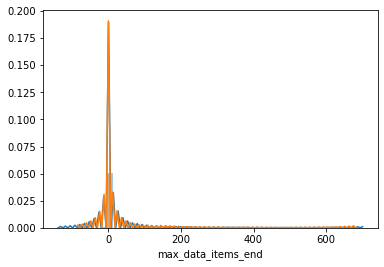

In [101]:
sns.distplot(train.max_data_items_end.fillna(0))
sns.distplot(test.max_data_items_end.fillna(0))
plt.show()

In [102]:
train.to_pickle('./input/train.pkl')
test.to_pickle('./input/test.pkl')

In [103]:
holdout = train[train.campaign_id.isin([5,9,13])].reset_index(drop=True)
train = train[~train.campaign_id.isin([5,9,13])].reset_index(drop=True)

In [106]:
train.columns[20:]

Index(['coupon_brands', 'coupon_discount', 'coupon_discount mean',
       'coupon_discount mean_1', 'coupon_discount skew',
       'coupon_discount skew_1', 'coupon_discount std',
       'coupon_discount std_1', 'coupon_discount_skew', 'coupon_discount_std',
       'coupon_id', 'coupon_item_id', 'coupon_item_price_list', 'cust_brands',
       'cust_item_id', 'cust_medp', 'customer_id', 'customer_items_cnt',
       'customer_preferred_items', 'customer_transaction_cnt', 'date max',
       'date max_1', 'date min', 'date min_1', 'end_date', 'family_size',
       'g_coupon_discount_mean', 'g_coupon_discount_std',
       'g_customer_items_cnt', 'g_customer_transaction_cnt',
       'g_other_discount_mean', 'g_other_discount_std', 'g_selling_price_mean',
       'g_selling_price_std', 'id', 'income_bracket', 'item_cnt',
       'item_q25_ip', 'item_q50_ip', 'item_q75_ip', 'item_q90_ip',
       'item_q95_ip', 'marital_status', 'matching_item', 'matching_item_ratio',
       'no_of_children', 'nu

In [114]:
features_columns=[ 
    'campaign_id','start_date','end_date',
    'coupon_id', #'customer_id',
    'age_range', 'marital_status', 'rented', 'family_size',
    'no_of_children', 'income_bracket', 'item_cnt', 'Bakery',
    #'Dairy, Juices & Snacks', #'Flowers & Plants', 'Garden', 
    #'Grocery',
    #'Meat', 'Miscellaneous', 
    'Natural Products', #'Packaged Meat',
    'Pharmaceutical', #'Prepared Food', 'Restauarant', 'Salads', 'Seafood',
    #'Skin & Hair Care', 'Travel', 'Vegetables (cut)',
    'nunq_brand',
    'nunq_cat', 'nunq_brand_type',
    'cid_cnt',
    'customer_cnt',
    'nunq_customer',
    'nunq_campaign_coupon',
    'nunq_customer_coupon',
    'nunq_coupon_customer',
    'nunq_customer_campaign',
    'nunq_coupon_campaign',
    'customer_cid_cnt',
    'customer_coupon_cnt',
    'cid_coupon_cnt',
    
    #'other_discount',
    #'coupon_discount',
    #'other_discount_skew', 
    #'coupon_discount_skew', 
    
    'selling_price',
    'other_discount_std', 
    'coupon_discount_std', 
    'selling_price_std',
    'selling_price_skew',
    'customer_transaction_cnt',
    'customer_items_cnt',
    'matching_item',
    'matching_item_ratio',
    'num_matching_brand',
    'g_selling_price_mean',
    'g_customer_transaction_cnt',
    
    #'selling_price mean', 
    'selling_price std',
    'selling_price skew', 
    #'selling_price count', 
    #'other_discount mean',
    'other_discount std', 
    'other_discount skew', 
    #'coupon_discount mean',
    'coupon_discount std', 
    'coupon_discount skew',
    'min_data_items_end','max_data_items_end',
    #'coupon_item_selling_price_std','coupon_item_selling_price_mean'
    
    'num_expensive_items', 'num_matching_brand',
    'num_moderate_items',
    'item_q25_ip', 'item_q50_ip', 'item_q75_ip', 'item_q90_ip',
       'item_q95_ip'
    
]

In [225]:
features_columns=[ 
    'campaign_id','start_date','end_date',
    'coupon_id', #'customer_id',
    'age_range', 'marital_status', 'rented', 'family_size',
    'no_of_children', 'income_bracket', 'item_cnt', 
    #'Natural Products', 
    #'Pharmaceutical',
    'nunq_brand',
    'nunq_cat', 'nunq_brand_type',
    'cid_cnt',
    'customer_cnt',
    'nunq_customer',
    'nunq_campaign_coupon',
    'nunq_customer_coupon',
    'nunq_coupon_customer',
    'nunq_customer_campaign',
    'nunq_coupon_campaign',
    'customer_cid_cnt',
    'customer_coupon_cnt',
    'cid_coupon_cnt',
    
    #'other_discount',
    #'coupon_discount',
    #'other_discount_skew', 
    #'coupon_discount_skew', 
    
    'selling_price',
    'other_discount_std', 
    'coupon_discount_std', 
    'selling_price_std',
    'selling_price_skew',
    'customer_transaction_cnt',
    'customer_items_cnt',
    'matching_item',
    'matching_item_ratio',
    'num_matching_brand',
    'g_selling_price_mean',
    'g_customer_transaction_cnt',
    
    #'selling_price mean', 
    'selling_price std',
    'selling_price skew', 
    'selling_price count_1', 
    #'other_discount mean',
    'other_discount std', 
    'other_discount skew', 
    #'coupon_discount mean',
    'coupon_discount std', 
    'coupon_discount skew',
    'min_data_items_end','max_data_items_end',
    #'min_data_items','max_data_items',
    #'coupon_item_selling_price_std','coupon_item_selling_price_mean'
    
    'num_expensive_items', #'num_matching_brand',
    'num_moderate_items',
    'item_q25_ip', 'item_q50_ip', 'item_q75_ip', 'item_q90_ip',
    'item_q95_ip','customer_preferred_items'
    
]

In [226]:
feats = features_columns.copy()

In [235]:
lgb_params = {
        'objective':'binary',
        'boosting_type':'gbdt',
        'metric':'auc',
        'n_jobs':-1,
        'learning_rate':0.005,
        'num_leaves': 12,
        'max_depth':-1,
        'tree_learner':'serial',
        'colsample_bytree': 0.7,
        'subsample_freq':1,
        'subsample':0.71,
        'n_estimators':8000,
        'min_child_samples':350,
        'max_bin':155,
        'verbose':-1,
        'seed': 123,
        'early_stopping_rounds':500
}

In [236]:
target='redemption_status'

In [242]:
train_unq_cid = train.campaign_id.unique()

folds = StratifiedKFold(n_splits=5,random_state=1234,shuffle=True)
#folds = KFold(n_splits=5,random_state=1234)
#folds = GroupKFold(n_splits=5)

X,y = train[feats], train[target]  

test4pred = test[feats].copy()
del test4pred['campaign_id'],test4pred['start_date'],test4pred['end_date']
submission = test[['id']].copy()


ho4pred = holdout[feats].copy()
del ho4pred['campaign_id'],ho4pred['start_date'],ho4pred['end_date']
hopred = holdout[['redemption_status']].copy()

split_groups = train['campaign_id']

oof = train[[target]].copy()

#for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y, groups=split_groups)):
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y,y)):
    
    tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
    vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]
    
    print(tr_x.campaign_id.unique(),'\n', tr_x.start_date.max(), tr_x.end_date.max())
    print(vl_x.campaign_id.unique(),'\n', vl_x.start_date.max(), vl_x.end_date.max())
    del tr_x['campaign_id'],tr_x['start_date'],tr_x['end_date']
    del vl_x['campaign_id'],vl_x['start_date'],vl_x['end_date']
    
    #target encode
    df2enc = tr_x.copy()
    df2enc['target'] = tr_y

    
    print(tr_x.columns)
    print(tr_x.shape,vl_x.shape)

    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)  

    estimator = lgb.train(
        lgb_params,
        tr_data,
        valid_sets = [tr_data, vl_data],
        verbose_eval = 100,#categorical_feature=['age_range', 'marital_status','marital_status']
    )  
    
    
    oof.loc[val_idx,'pred'] = estimator.predict(vl_x,num_iteration=estimator.best_iteration)
    oof.loc[val_idx,'pred'] = oof.loc[val_idx,'pred'].rank()/oof.loc[val_idx,'pred'].shape[0]
    
    submission['pred'+str(fold_)] = estimator.predict(test4pred,num_iteration=estimator.best_iteration)
    submission['pred'+str(fold_)] = submission['pred'+str(fold_)].rank()/submission['pred'+str(fold_)].shape[0]
    
    hopred['pred'+str(fold_)] = estimator.predict(ho4pred,num_iteration=estimator.best_iteration)
    
    feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),tr_x.columns)), columns=['Value','Feature'])
    print(feature_imp)
    #break
score = roc_auc_score(oof[target], oof.pred)
print(score)

[ 8 11 29 30  2 12 26  3  4 10  7 28 27  6  1] 
 2013-08-04 00:00:00 2013-10-05 00:00:00
[ 8 11 29 30  2 12 26  3  4 10  7 28 27  6  1] 
 2013-08-04 00:00:00 2013-10-05 00:00:00
Index(['coupon_id', 'age_range', 'marital_status', 'rented', 'family_size',
       'no_of_children', 'income_bracket', 'item_cnt', 'nunq_brand',
       'nunq_cat', 'nunq_brand_type', 'cid_cnt', 'customer_cnt',
       'nunq_customer', 'nunq_campaign_coupon', 'nunq_customer_coupon',
       'nunq_coupon_customer', 'nunq_customer_campaign',
       'nunq_coupon_campaign', 'customer_cid_cnt', 'customer_coupon_cnt',
       'cid_coupon_cnt', 'selling_price', 'other_discount_std',
       'coupon_discount_std', 'selling_price_std', 'selling_price_skew',
       'customer_transaction_cnt', 'customer_items_cnt', 'matching_item',
       'matching_item_ratio', 'num_matching_brand', 'g_selling_price_mean',
       'g_customer_transaction_cnt', 'selling_price std', 'selling_price skew',
       'selling_price count_1', 'other_dis

d:\Anaconda3.1\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
d:\Anaconda3.1\lib\site-packages\lightgbm\engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
[100]	training's auc: 0.954999	valid_1's auc: 0.947633
[200]	training's auc: 0.960766	valid_1's auc: 0.948934
[300]	training's auc: 0.966151	valid_1's auc: 0.95107
[400]	training's auc: 0.972463	valid_1's auc: 0.954668
[500]	training's auc: 0.977692	valid_1's auc: 0.955933
[600]	training's auc: 0.981898	valid_1's auc: 0.958431
[700]	training's auc: 0.985192	valid_1's auc: 0.959442
[800]	training's auc: 0.98821	valid_1's auc: 0.961223
[900]	training's auc: 0.990553	valid_1's auc: 0.962398
[1000]	training's auc: 0.992314	valid_1's auc: 0.963196
[1100]	training's auc: 0.99367	valid_1's auc: 0.963214
[1200]	training's auc: 0.99482	valid_1's auc: 0.964159
[1300]	training's auc: 0.995714	valid_1's auc: 0.964539
[1400]	training's auc: 0.996445	valid_1's auc: 0.96466
[1500]	training's auc: 0.997014	valid_1's auc: 0.965133
[1600]	training's auc: 0.997484	valid_1's auc: 0.964855
[1700]	training's auc: 0.99789	valid_1's auc: 0.964707


Training until validation scores don't improve for 500 rounds.
[100]	training's auc: 0.960692	valid_1's auc: 0.905829
[200]	training's auc: 0.966086	valid_1's auc: 0.908177
[300]	training's auc: 0.971432	valid_1's auc: 0.912506
[400]	training's auc: 0.978316	valid_1's auc: 0.917586
[500]	training's auc: 0.982834	valid_1's auc: 0.921018
[600]	training's auc: 0.986165	valid_1's auc: 0.924064
[700]	training's auc: 0.98856	valid_1's auc: 0.926763
[800]	training's auc: 0.990576	valid_1's auc: 0.927398
[900]	training's auc: 0.992245	valid_1's auc: 0.92845
[1000]	training's auc: 0.993578	valid_1's auc: 0.92866
[1100]	training's auc: 0.994724	valid_1's auc: 0.929705
[1200]	training's auc: 0.995724	valid_1's auc: 0.929998
[1300]	training's auc: 0.996513	valid_1's auc: 0.930305
[1400]	training's auc: 0.997142	valid_1's auc: 0.930965
[1500]	training's auc: 0.997651	valid_1's auc: 0.931722
[1600]	training's auc: 0.998058	valid_1's auc: 0.931744
[1700]	training's auc: 0.998389	valid_1's auc: 0.9325

Training until validation scores don't improve for 500 rounds.
[100]	training's auc: 0.95651	valid_1's auc: 0.934813
[200]	training's auc: 0.961245	valid_1's auc: 0.937106
[300]	training's auc: 0.966602	valid_1's auc: 0.939933
[400]	training's auc: 0.97268	valid_1's auc: 0.944359
[500]	training's auc: 0.978049	valid_1's auc: 0.948897
[600]	training's auc: 0.982908	valid_1's auc: 0.953343
[700]	training's auc: 0.986432	valid_1's auc: 0.956052
[800]	training's auc: 0.988905	valid_1's auc: 0.957504
[900]	training's auc: 0.990984	valid_1's auc: 0.958742
[1000]	training's auc: 0.992712	valid_1's auc: 0.960097
[1100]	training's auc: 0.993895	valid_1's auc: 0.960909
[1200]	training's auc: 0.995055	valid_1's auc: 0.961165
[1300]	training's auc: 0.995928	valid_1's auc: 0.961124
[1400]	training's auc: 0.996598	valid_1's auc: 0.961286
[1500]	training's auc: 0.997156	valid_1's auc: 0.96176
[1600]	training's auc: 0.99762	valid_1's auc: 0.961891
[1700]	training's auc: 0.998047	valid_1's auc: 0.96175

In [243]:
hopred['mean_pred'] = (hopred.filter(regex='pred')).mean(axis=1)
scr=roc_auc_score(hopred[target], hopred.mean_pred)
print(scr)

0.9454240665846083


In [244]:
hopred['rank_pred'] = (hopred.filter(regex='pred').rank()/hopred.shape[0]).mean(axis=1)
scr=roc_auc_score(hopred[target], hopred.rank_pred)
print(scr)

0.945848230857902


In [248]:
train = pd.read_pickle('./input/train.pkl')
test = pd.read_pickle('./input/test.pkl')

In [301]:
features_columns=[ 
    'campaign_id','start_date','end_date',
    'coupon_id', #'customer_id',
    'age_range', 'marital_status', 'rented', 'family_size',
    'no_of_children', 'income_bracket', 'item_cnt', 'Bakery',
    'Dairy, Juices & Snacks', #'Flowers & Plants', 'Garden', 
    #'Grocery',
    #'Meat', 'Miscellaneous', 
    'Natural Products', #'Packaged Meat',
    'Pharmaceutical', #'Prepared Food', 'Restauarant', 'Salads', 'Seafood',
    #'Skin & Hair Care', 'Travel', 'Vegetables (cut)',
    'nunq_brand',
    'nunq_cat', 'nunq_brand_type',
    'cid_cnt',
    'customer_cnt',
    'nunq_customer',
    'nunq_campaign_coupon',
    'nunq_customer_coupon',
    'nunq_coupon_customer',
    'nunq_customer_campaign',
    'nunq_coupon_campaign',
    'customer_cid_cnt',
    'customer_coupon_cnt',
    'cid_coupon_cnt',
    'other_discount',
    'coupon_discount',
    'selling_price',
    'other_discount_std', 
    'coupon_discount_std', 
    'selling_price_std',
    
    'other_discount_skew', 
    #'coupon_discount_skew', 
    'selling_price_skew',
    
    'customer_transaction_cnt',
    'customer_items_cnt',
    'matching_item',
    'num_matching_brand',
    'g_selling_price_mean',
    'g_customer_transaction_cnt',
    'selling_price mean', 'selling_price std',
    'selling_price skew', 'selling_price count', 'other_discount mean',
    'other_discount std', 'other_discount skew', 'coupon_discount mean',
    'coupon_discount std', 'coupon_discount skew',
    'num_expensive_items', 'num_matching_brand',
    'num_moderate_items',
    'item_q25_ip', 'item_q50_ip', 'item_q75_ip', 'item_q90_ip',
       'item_q95_ip',#'matching_item_ratio',
]

In [302]:
feats = features_columns.copy()

In [332]:
lgb_params = {
        'objective':'binary',
        'boosting_type':'gbdt',
        'metric':'auc',
        'n_jobs':-1,
        'learning_rate':0.005,
        'num_leaves': 20,
        'max_depth':-1,
        'tree_learner':'serial',
        'colsample_bytree': 0.66,
        'subsample_freq':10,
        'subsample':0.71,
        'n_estimators':8000,
        'min_child_samples':250,
        'max_bin':155,
        'verbose':-1,
        'seed': 1243,
        'scale_pos_weight':1,
        'early_stopping_rounds':500
}

In [ ]:
subms=[]
for bg in range(5):
    lgb_params['seed'] = bg
    train_unq_cid = train.campaign_id.unique()

    #folds = StratifiedKFold(n_splits=5,random_state=1234,shuffle=True)
    #folds = KFold(n_splits=5,random_state=1234)
    folds = GroupKFold(n_splits=5)

    X,y = train[feats], train[target]  

    test4pred = test[feats].copy()
    del test4pred['campaign_id'],test4pred['start_date'],test4pred['end_date']
    submission = test[['id']].copy()


    split_groups = train['campaign_id']

    oof = train[[target]].copy()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y, groups=split_groups)):
    #for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y,y)):

        tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
        vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]

        print(tr_x.campaign_id.unique(),'\n', tr_x.start_date.max(), tr_x.end_date.max())
        print(vl_x.campaign_id.unique(),'\n', vl_x.start_date.max(), vl_x.end_date.max())
        del tr_x['campaign_id'],tr_x['start_date'],tr_x['end_date']
        del vl_x['campaign_id'],vl_x['start_date'],vl_x['end_date']

        #target encode
        df2enc = tr_x.copy()
        df2enc['target'] = tr_y


        print(tr_x.columns)
        print(tr_x.shape,vl_x.shape)

        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)  

        estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data, vl_data],
            verbose_eval = 100,#categorical_feature=['age_range', 'marital_status','marital_status']
        )  


        oof.loc[val_idx,'pred'] = estimator.predict(vl_x,num_iteration=estimator.best_iteration)
        oof.loc[val_idx,'pred'] = oof.loc[val_idx,'pred'].rank()/oof.loc[val_idx,'pred'].shape[0]

        submission['pred'+str(fold_)] = estimator.predict(test4pred,num_iteration=estimator.best_iteration)
        submission['pred'+str(fold_)] = submission['pred'+str(fold_)].rank()/submission['pred'+str(fold_)].shape[0]
        feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),tr_x.columns)), columns=['Value','Feature'])
        print(feature_imp)
        #break
    score = roc_auc_score(oof[target], oof.pred)
    print(score)
    
    subms.append(submission)

[ 9  8 11 29 30  2  5 12 26  3  4 10  7 28 27  6  1] 
 2013-12-01 00:00:00 2013-12-04 00:00:00
[13] 
 2013-05-19 00:00:00 2013-05-07 00:00:00
Index(['coupon_id', 'age_range', 'marital_status', 'rented', 'family_size',
       'no_of_children', 'income_bracket', 'item_cnt', 'Bakery',
       'Dairy, Juices & Snacks', 'Natural Products', 'Pharmaceutical',
       'nunq_brand', 'nunq_cat', 'nunq_brand_type', 'cid_cnt', 'customer_cnt',
       'nunq_customer', 'nunq_campaign_coupon', 'nunq_customer_coupon',
       'nunq_coupon_customer', 'nunq_customer_campaign',
       'nunq_coupon_campaign', 'customer_cid_cnt', 'customer_coupon_cnt',
       'cid_coupon_cnt', 'other_discount', 'coupon_discount', 'selling_price',
       'other_discount_std', 'coupon_discount_std', 'selling_price_std',
       'other_discount_skew', 'selling_price_skew', 'customer_transaction_cnt',
       'customer_items_cnt', 'matching_item', 'num_matching_brand',
       'g_selling_price_mean', 'g_customer_transaction_cnt',
   

d:\Anaconda3.1\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
d:\Anaconda3.1\lib\site-packages\lightgbm\engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
[100]	training's auc: 0.968679	valid_1's auc: 0.935806
[200]	training's auc: 0.974572	valid_1's auc: 0.938148
[300]	training's auc: 0.979805	valid_1's auc: 0.939556
[400]	training's auc: 0.984026	valid_1's auc: 0.939853
[500]	training's auc: 0.988414	valid_1's auc: 0.941
[600]	training's auc: 0.991737	valid_1's auc: 0.941083
[700]	training's auc: 0.994182	valid_1's auc: 0.941521
[800]	training's auc: 0.995577	valid_1's auc: 0.941407
[900]	training's auc: 0.996583	valid_1's auc: 0.940637
[1000]	training's auc: 0.997299	valid_1's auc: 0.940035
[1100]	training's auc: 0.997924	valid_1's auc: 0.939941
Early stopping, best iteration is:
[691]	training's auc: 0.994011	valid_1's auc: 0.941673
    Value                     Feature
0       0                      Bakery
1       1             nunq_brand_type
2       4                    nunq_cat
3       7      Dairy, Juices & Snacks
4      21      nunq_customer_campaign
5      22      

Training until validation scores don't improve for 500 rounds.
[100]	training's auc: 0.963693	valid_1's auc: 0.853455
[200]	training's auc: 0.969992	valid_1's auc: 0.856889
[300]	training's auc: 0.974317	valid_1's auc: 0.859228
[400]	training's auc: 0.979202	valid_1's auc: 0.862989
[500]	training's auc: 0.983534	valid_1's auc: 0.866471
[600]	training's auc: 0.987294	valid_1's auc: 0.871327
[700]	training's auc: 0.989666	valid_1's auc: 0.874255
[800]	training's auc: 0.99139	valid_1's auc: 0.876102
[900]	training's auc: 0.992937	valid_1's auc: 0.877144
[1000]	training's auc: 0.994087	valid_1's auc: 0.877522
[1100]	training's auc: 0.995038	valid_1's auc: 0.878012
[1200]	training's auc: 0.995767	valid_1's auc: 0.878748
[1300]	training's auc: 0.996387	valid_1's auc: 0.880097
[1400]	training's auc: 0.996896	valid_1's auc: 0.880527
[1500]	training's auc: 0.997337	valid_1's auc: 0.878436
[1600]	training's auc: 0.997718	valid_1's auc: 0.876691
[1700]	training's auc: 0.99804	valid_1's auc: 0.876

In [311]:
fin_subm = submission[['id']].copy()
fin_subm[target] = 0
for bg in range(5):
    fin_subm[target] += subms[bg].filter(regex='pred').mean(axis=1)
fin_subm[target]/=5

In [312]:
fin_subm.to_csv('./model-re-analysis-cv9396v3.csv',index=False)

In [310]:
print([fin_subm])

[           id  redemption_status
0           3           0.992623
1           5           0.732155
2          16           0.196403
3          31           0.407558
4          38           0.461978
...       ...                ...
50221  125974           0.365577
50222  126376           0.832579
50223  126633           0.986133
50224  126682           0.941015
50225  127955           0.823655

[50226 rows x 2 columns]]
